In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         # just get the individual folder names
#         print(os.path.join(dirname, filename))
#         break

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("orvile/brain-cancer-mri-dataset")

# print("Path to dataset files:", path)

# import the required Libraries

In [1]:
import pandas as pd
import subprocess
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import joblib

2025-05-18 06:27:35.476709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747549655.494499    2336 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747549655.499998    2336 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747549655.516776    2336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747549655.516807    2336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747549655.516809    2336 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 70% of memory on the first GPU
    def get_gpu_memory():
        command = "nvidia-smi --query-gpu=memory.free --format=csv"
        memory_free_info = subprocess.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
        return memory_free_values
    
    mem = get_gpu_memory()
    mem = int(0.7*mem[0])
    
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem)])
        print(f"Allocated a tensorflow object 70% ({mem}MB) of memory for this standalone notebook.")
    except:
        print("Failed to allocate GPU memory")

Allocated a tensorflow object 70% (2774MB) of memory for this standalone notebook.


# view the dataset information

In [4]:
df = pd.read_csv("dataset.csv")
df.head()

# the number of images are not far off

,label,number_of_files
0,brain_glioma,2004
1,brain_menin,2004
2,brain_tumor,2048


# dataset generation

In [3]:
batchsize = 16
imgsize = 224
channels = 3

In [4]:
trainer, valer = tf.keras.utils.image_dataset_from_directory(
    "Brain_Cancer raw MRI data/Brain_Cancer/",
    batch_size=batchsize,
    shuffle=True,
    validation_split=0.25,
    label_mode = "categorical",
    seed=17,
    subset="both",
    image_size=(imgsize,imgsize)
)

Found 6056 files belonging to 3 classes.
Using 4542 files for training.
Using 1514 files for validation.


I0000 00:00:1747549667.883985    2336 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2774 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


create testing and validation sets

In [7]:
val_batches = tf.data.experimental.cardinality(valer)
tester = valer.take((2*val_batches) // 3)
valer = valer.skip((2*val_batches) // 3)

# plots

In [5]:
classnames = trainer.class_names

joblib.dump(classnames, "classnames.pkl")

['classnames.pkl']

2025-05-17 10:51:55.961845: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


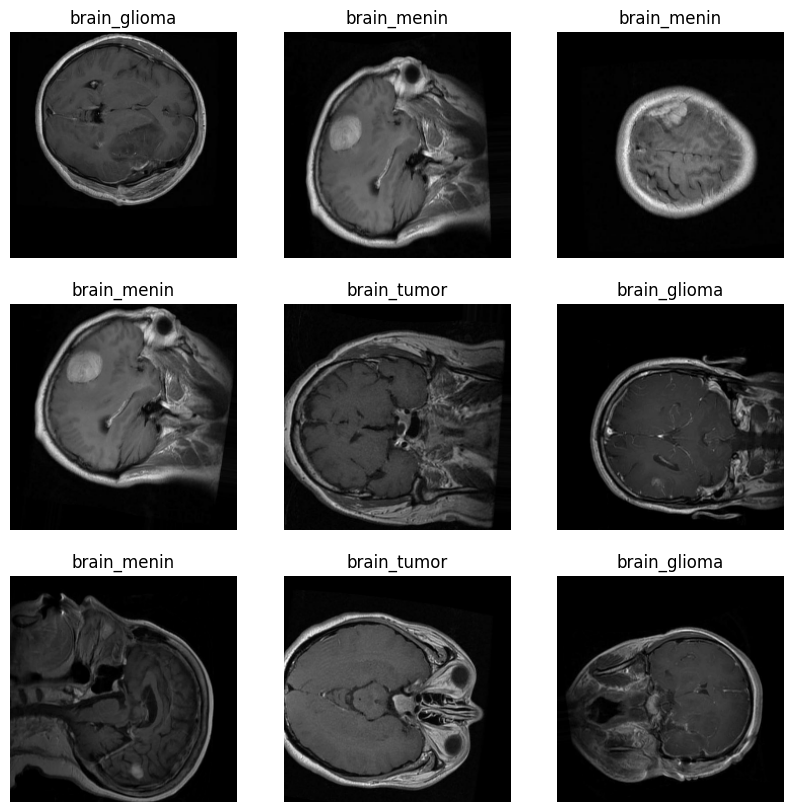

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in trainer.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[np.where(labels[i].numpy() == 1.)[0][0]])
        plt.axis("off")

# model creation and training

In [6]:
inputlayer = tf.keras.layers.Resizing(imgsize, imgsize)
inputlayer = tf.keras.layers.InputLayer(shape = (imgsize,imgsize,channels))
inputlayer = tf.keras.layers.RandomFlip("horizontal_and_vertical")(inputlayer.output)
inputlayer = tf.keras.layers.RandomRotation(0.2)(inputlayer)
inputlayer = tf.keras.layers.RandomZoom(0.2)(inputlayer)

# Pretrained models to Concat

In [7]:
# i have selected these models after a simple theoritical reading, you may use other models. mileage varies

# mobilenetv3 large
modelMobilenet3Large = tf.keras.applications.MobileNetV3Large(
    input_shape=(imgsize, imgsize,channels),
    alpha=1.0,
    include_top = False,
    weights='imagenet',
    classes = len(classnames),
    classifier_activation="softmax",
    pooling="avg"
)
for layers in modelMobilenet3Large.layers:
    layers.trainable=False
    layers.name = layers.name + ("mmbl")

modelMobilenet3Large = modelMobilenet3Large(inputlayer)
modelMobilenet3Large = tf.keras.layers.Flatten()(modelMobilenet3Large)
modelMobilenet3Large = tf.keras.layers.BatchNormalization()(modelMobilenet3Large)
modelMobilenet3Large = tf.keras.layers.Dense(200,activation='relu')(modelMobilenet3Large)

# resnet50v2
ResNet50V2 = tf.keras.applications.ResNet50V2(
    input_shape=(imgsize, imgsize,channels),
    include_top = False,
    weights='imagenet',
    classes = len(classnames),
    classifier_activation="softmax",
    pooling="avg"
)
for layers in ResNet50V2.layers:
    layers.trainable=False
    layers.name = layers.name + ("rsnt50")

ResNet50V2 = ResNet50V2(inputlayer)
ResNet50V2 = tf.keras.layers.Flatten()(ResNet50V2)
ResNet50V2 = tf.keras.layers.BatchNormalization()(ResNet50V2)
ResNet50V2 = tf.keras.layers.Dense(200,activation='relu')(ResNet50V2)

# vgg19
modelVGG19 = tf.keras.applications.VGG19(
    input_shape=(imgsize, imgsize,channels),
    include_top = False,
    weights='imagenet',
    classes = len(classnames),
    classifier_activation="softmax",
    pooling="avg"
)
for layers in modelVGG19.layers:
    layers.trainable=False
    layers.name = layers.name + ("vgg19")

modelVGG19 = modelVGG19(inputlayer)
modelVGG19 = tf.keras.layers.Flatten()(modelVGG19)
modelVGG19 = tf.keras.layers.BatchNormalization(name="batchnorm1")(modelVGG19)
modelVGG19 = tf.keras.layers.Dense(200,activation='relu')(modelVGG19)

In [8]:
multiinter = tf.keras.layers.Concatenate()([modelMobilenet3Large, modelVGG19, ResNet50V2])
multiinter = tf.keras.layers.Dense(len(classnames),activation="softmax")(multiinter)

Multi = tf.keras.models.Model(inputs=inputlayer, outputs=multiinter)
Multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
Multi.summary(expand_nested=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_3CLONE │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 960)       │  2,996,352 │ keras_tensor_3CL… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 224, 224,  │          0 │ -                 │
│ input_layer_1mmbl   │ 3)                │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ rescalingmmbl  │ (None, 224, 224,  │          0 │ -                 │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ convmmbl       │ (None, 112, 112,  │        432 │ -                 │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ conv_bnmmbl    │ (None, 112, 112,  │         64 │ -                 │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ activationmmbl │ (None, 112, 112,  │          0 │ -                 │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │        144 │ -                 │
│ expanded_conv_dept… │ 16)               │            │                   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │         64 │ -                 │
│ expanded_conv_dept… │ 16)               │            │                   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ re_lummbl      │ (None, 112, 112,  │          0 │ -                 │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │        256 │ -                 │
│ expanded_conv_proj… │ 16)               │            │                   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │         64 │ -                 │
│ expanded_conv_proj… │ 16)               │            │                   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │          0 │ -                 │
│ expanded_conv_addm… │ 16)               │            │                   │
│ (Add)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 112, 112,  │      1,024 │ -                 │
│ expanded_conv_1_ex… │ 64)               │            │                   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 47,306,019 (180.46 MB)

 Trainable params: 713,443 (2.72 MB)

 Non-trainable params: 46,592,576 (177.74 MB)

In [17]:
dotm = tf.keras.utils.model_to_dot(Multi, expand_nested=True, show_layer_activations=True, show_shapes=True)
dotm.write_png("out.png")

# Training

In [15]:
callbacks = [EarlyStopping(patience=15,min_delta=0.2,monitor='val_accuracy',mode='auto',restore_best_weights=True),
             EarlyStopping(patience=9,min_delta=0.05,monitor='val_loss',mode='auto',restore_best_weights=True),
             ModelCheckpoint("chkpnt.keras",save_best_only=True)]

In [16]:
hist = Multi.fit(trainer, validation_data=valer,batch_size = batchsize, epochs=50, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1747479140.026681    7647 service.cc:152] XLA service 0x7501f40020d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747479140.026777    7647 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-17 10:52:20.813471: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747479144.939758    7647 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-17 10:52:37.610776: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng39{k25=2} for conv %cudnn-conv-bias-activation.213 = (f32[16,120,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,480,1,1]{3,2,1,0} %bitcast.13407, f32[120,480,1,1]{3,2,1,0} %bitcast.13414, f32[120]{0} %bitcast.13416), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwar

283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8569 - loss: 0.4247

2025-05-17 10:53:46.812904: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng20{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0} for conv %cudnn-conv-bias-activation.224 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,64,224,224]{3,2,1,0} %bitcast.14408, f32[64,64,3,3]{3,2,1,0} %bitcast.14415, f32[64]{0} %bitcast.14417), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg19_1/block1_conv2vgg19_1/convolution" source_file="/home/sidthechillguy/miniconda3/envs/tensorflow/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-17 10:53:46.836232: E external/local_xla/xla/se

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8571 - loss: 0.4242

2025-05-17 10:54:04.708154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-17 10:54:20.873931: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv %cudnn-conv-bias-activation.215 = (f32[10,168,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,672,1,1]{3,2,1,0} %bitcast.11919, f32[168,672,1,1]{3,2,1,0} %bitcast.11926, f32[168]{0} %bitcast.11928), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/MobileNetV3Large_1/expanded_conv_11_squeeze_excite_convmmbl_1/convolution" source_file="/home/sidthechillguy/miniconda3/envs/tensorflow/lib/python3.12/site-packa

284/284 ━━━━━━━━━━━━━━━━━━━━ 162s 407ms/step - accuracy: 0.8573 - loss: 0.4236 - val_accuracy: 0.9545 - val_loss: 0.1039
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9794 - loss: 0.0702

2025-05-17 10:55:40.014318: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 68s 238ms/step - accuracy: 0.9794 - loss: 0.0702 - val_accuracy: 0.9842 - val_loss: 0.0547
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9847 - loss: 0.0485

2025-05-17 10:56:41.780889: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-17 10:56:42.479141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - accuracy: 0.9847 - loss: 0.0485 - val_accuracy: 0.9763 - val_loss: 0.0611
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9893 - loss: 0.0301

2025-05-17 10:57:27.160312: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.9893 - loss: 0.0301 - val_accuracy: 0.9842 - val_loss: 0.0372
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9884 - loss: 0.0316

2025-05-17 10:58:37.046396: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9634048 bytes after encountering the first element of size 9634048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - accuracy: 0.9884 - loss: 0.0316 - val_accuracy: 0.9822 - val_loss: 0.0549
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9792 - loss: 0.0745

2025-05-17 10:59:21.702576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9634048 bytes after encountering the first element of size 9634048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.9792 - loss: 0.0745 - val_accuracy: 0.9763 - val_loss: 0.0997
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9907 - loss: 0.0355

2025-05-17 11:00:06.143090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 62s 217ms/step - accuracy: 0.9907 - loss: 0.0354 - val_accuracy: 0.9862 - val_loss: 0.0332
Epoch 8/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9905 - loss: 0.0333

2025-05-17 11:01:08.567132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9634048 bytes after encountering the first element of size 9634048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 62s 217ms/step - accuracy: 0.9905 - loss: 0.0333 - val_accuracy: 0.9921 - val_loss: 0.0226
Epoch 9/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9959 - loss: 0.0131

2025-05-17 11:02:10.152829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.9958 - loss: 0.0131 - val_accuracy: 0.9763 - val_loss: 0.0843
Epoch 10/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9871 - loss: 0.0449

2025-05-17 11:02:54.447211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9634048 bytes after encountering the first element of size 9634048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.9871 - loss: 0.0449 - val_accuracy: 0.9783 - val_loss: 0.1183
Epoch 11/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9868 - loss: 0.0539

2025-05-17 11:03:38.583285: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 47s 166ms/step - accuracy: 0.9868 - loss: 0.0538 - val_accuracy: 0.9901 - val_loss: 0.0300
Epoch 12/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9948 - loss: 0.0206

2025-05-17 11:04:25.679796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9634048 bytes after encountering the first element of size 9634048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.9948 - loss: 0.0206 - val_accuracy: 0.9842 - val_loss: 0.1090
Epoch 13/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9936 - loss: 0.0205

2025-05-17 11:05:09.970918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 0.9862 - val_loss: 0.0499


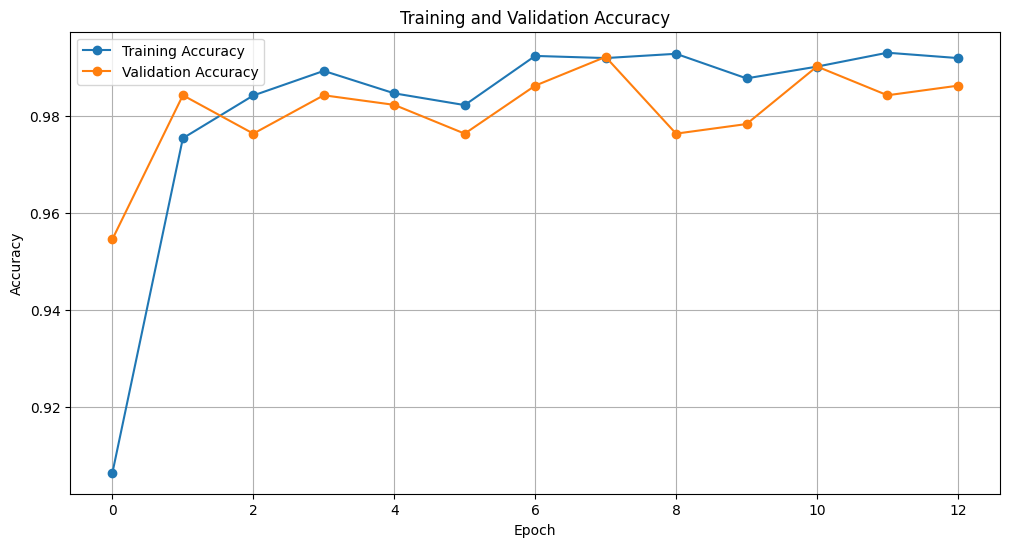

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

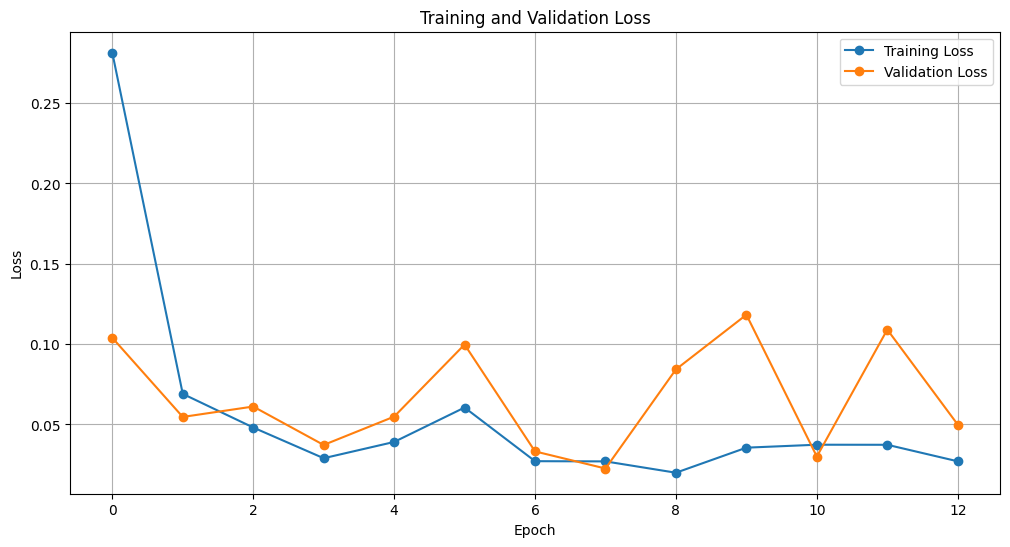

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss', marker='o')
plt.plot(hist.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
Multi.save("Model.keras")

# Evaluation

In [20]:
Multi.evaluate(tester)

2025-05-17 11:05:36.694467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9747 - loss: 0.0869


[0.06731519848108292, 0.9791666865348816]

2025-05-17 11:05:45.059589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step


2025-05-17 11:06:14.117219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-17 11:06:17.338514: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
               precision    recall  f1-score   support

brain_glioma       0.99      0.99      0.99       339
 brain_menin       0.95      0.99      0.97       307
 brain_tumor       0.99      0.96      0.98       362

    accuracy                           0.98      1008
   macro avg       0.98      0.98      0.98      1008
weighted avg       0.98      0.98      0.98      1008



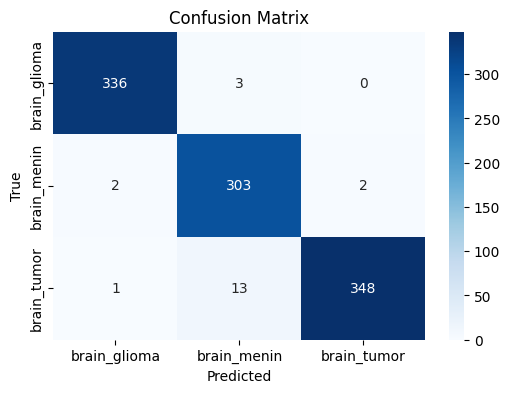

ROC AUC Score: 0.999121733269693


In [21]:
y_pred_probs = Multi.predict(tester)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in tester:
    for i in labels.numpy():
        y_true.append(np.where(i == 1.)[0][0])

print(f"Classification Report:\n {classification_report(y_true, y_pred, target_names=classnames)}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classnames, yticklabels=classnames, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovr')
print("ROC AUC Score:", roc_auc)